In [30]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [3]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [4]:
df.shape

(169, 2)

#### Renaming the column

In [5]:
df.rename(columns={'Monthly milk production: pounds per cow. Jan 62 ? Dec 75':'milk_in_pounds'},inplace=True)

In [6]:
df.head()

,Month,milk_in_pounds
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [7]:
df.tail()

,Month,milk_in_pounds
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


#### Dropping the last row as it contains noise data

In [8]:
df.drop(168,axis=0,inplace=True)

In [9]:
df.tail()

,Month,milk_in_pounds
163,1975-08,858.0
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Month           168 non-null    object 
 1   milk_in_pounds  168 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


#### Converting the data type of Month column to datetime

In [11]:
df['Month'] = pd.to_datetime(df['Month'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Month           168 non-null    datetime64[ns]
 1   milk_in_pounds  168 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


#### Making the month column as index

In [13]:
df.set_index('Month',inplace=True)

In [14]:
df.head()

,milk_in_pounds
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [15]:
df.describe()

,milk_in_pounds
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


#### Plotting the data

<AxesSubplot:xlabel='Month', ylabel='milk_in_pounds'>

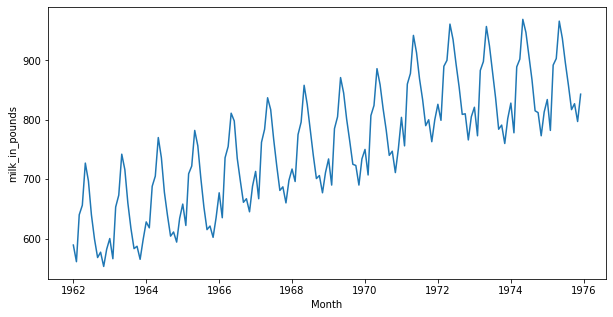

In [16]:
plt.figure(figsize=(10,5))
sb.lineplot(x=df.index,y=df['milk_in_pounds'])

### Check whether timeseries is stationary or not.

##### 1. Rolling statistics

###### 1. checking the mean

<AxesSubplot:xlabel='Month'>

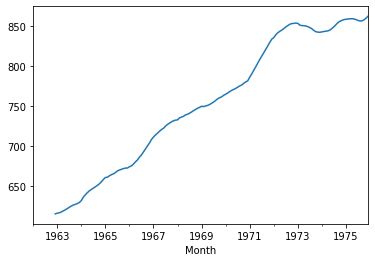

In [17]:
df['milk_in_pounds'].rolling(12).mean().plot()

Mean is not constant - hence it is non-stationary

###### 2. checking the standard deviation

<AxesSubplot:xlabel='Month'>

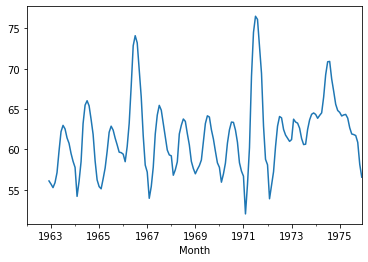

In [18]:
df['milk_in_pounds'].rolling(12).std().plot()

STD is also not constant - non-stationary

#### 2. Augmented Dickey-fuller test

In [19]:
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(df['milk_in_pounds'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -1.303812
p-value                          0.627427
#lags used                      13.000000
number of observations used    154.000000
critical value (1%)             -3.473543
critical value (5%)             -2.880498
critical value (10%)            -2.576878
dtype: float64


Test statistic is more than critical value at different % , Hence Null hypothesis (time series is non-stationary) is accepted.

#### Seasonal decomposition / Classical decomposition

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['milk_in_pounds'],extrapolate_trend=12)

<Figure size 432x288 with 0 Axes>

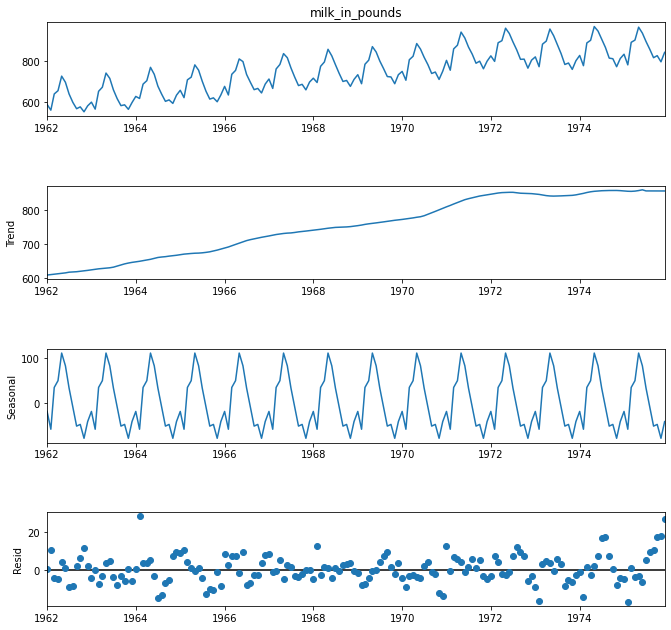

In [21]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10,10)

#### Differencing - to convert non-stationary to stationary

In [22]:
#1st Order differencing and remove the trend part
trend_removed = df['milk_in_pounds']-df['milk_in_pounds'].shift(1)

In [23]:
# 1st order seasonal differencing to remove the seasonal factor
trend_seasonality_removed = trend_removed-trend_removed.shift(12)

In [24]:
trend_seasonality_removed = trend_seasonality_removed.dropna()

<AxesSubplot:xlabel='Month'>

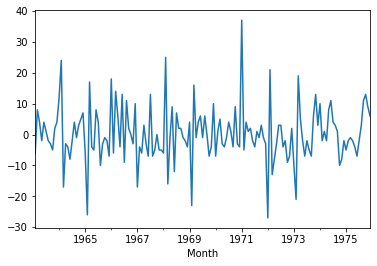

In [25]:
trend_seasonality_removed.plot()

In [26]:
print("Observations of Dickey-fuller test")
dftest = adfuller(trend_seasonality_removed,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -5.038002
p-value                          0.000019
#lags used                      11.000000
number of observations used    143.000000
critical value (1%)             -3.476927
critical value (5%)             -2.881973
critical value (10%)            -2.577665
dtype: float64


Here Null hypothesis is rejected - hence Time series is STATIONARY now.

### ACF and PACF - to find the values of p,q

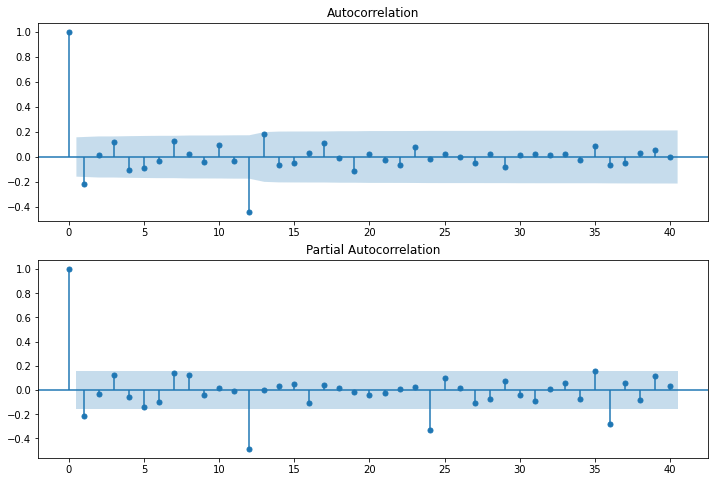

In [31]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_seasonality_removed,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_seasonality_removed,lags=40,ax=ax2)

p - 0,1,12
q - 0,1,12

combinations - (0,0),(0,1),(0,12),(1,0),(1,1),(1,12),(12,0),(12,1),(12,12)

### Do the modelling

In [61]:
from statsmodels.tsa.arima_model import ARIMA
model = sm.tsa.statespace.SARIMAX(trend_seasonality_removed,order=(1,1,1),seasonal_order=(1,1,1,12))

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [62]:
results = model.fit()

In [63]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     milk_in_pounds   No. Observations:                  155
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -520.423
Date:                            Wed, 19 Jan 2022   AIC                           1050.846
Time:                                    13:08:02   BIC                           1065.625
Sample:                                02-01-1963   HQIC                          1056.851
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2311      0.078     -2.977      0.003      -0.383      -0.079
ma.L1         -0.9998      6.754     -0.148      0.882     -14.237      12.238
ar.S.L12      -0.4272      0.070     -6.061      0.000      -0.565      -0.289
ma.S.L12      -0.9999    286.037     -0.003      0.997    -561.622     559.623
sigma2        62.9182    1.8e+04      0.003      0.997   -3.53e+04    3.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                18.53
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.33
Prob(H) (two-sided):                  0.84   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Showing the Residual plot

<AxesSubplot:xlabel='Month'>

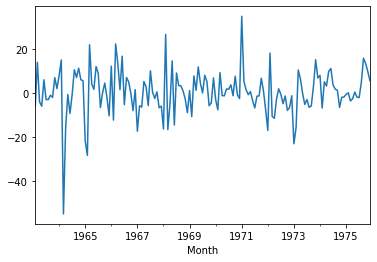

In [64]:
results.resid.plot()

### Predicting the value on trained data

In [73]:
data = pd.DataFrame(trend_seasonality_removed)

In [81]:
data['Forecast'] = results.predict(start=50,end=100,dynamic=True)

In [82]:
data.head()

,milk_in_pounds,Forecast
Month,,
1963-02-01,-6.0,NaN
1963-03-01,8.0,NaN
1963-04-01,4.0,NaN
1963-05-01,-2.0,NaN
1963-06-01,4.0,NaN


<AxesSubplot:xlabel='Month'>

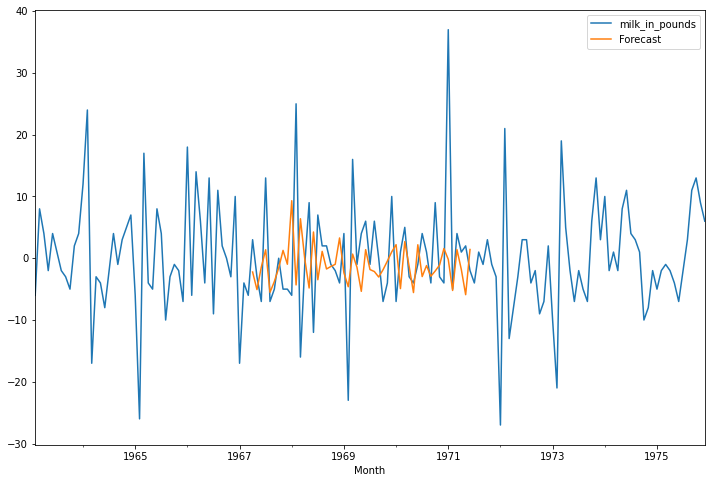

In [83]:
data[['milk_in_pounds','Forecast']].plot(figsize=(12,8))

Blue line - Actual values
Orange line - predicted values

### Predict the value for unseen data

In [85]:
data.shape

(155, 2)

In [86]:
data.tail()

,milk_in_pounds,Forecast
Month,,
1975-08-01,3.0,NaN
1975-09-01,11.0,NaN
1975-10-01,13.0,NaN
1975-11-01,9.0,NaN
1975-12-01,6.0,NaN


#### Predicting for next 1 year

<AxesSubplot:>

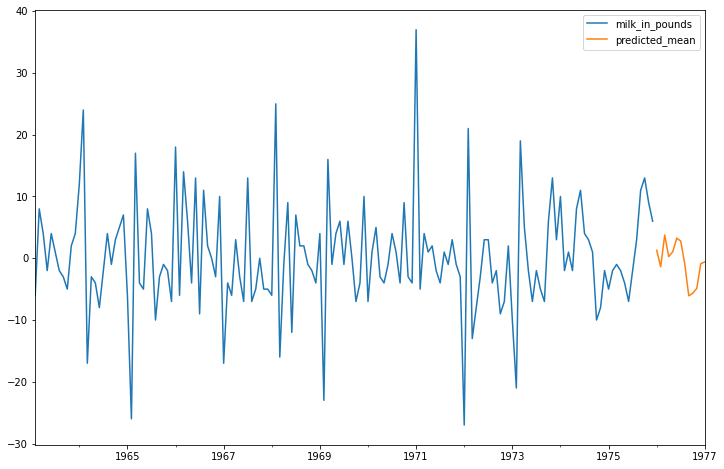

In [95]:
pd.concat([data,pd.DataFrame(results.predict(start=155,end=167,dynamic=True))],axis=0)[['milk_in_pounds','predicted_mean']].plot(figsize=(12,8))

orange line is the predicted line for next 12 months